In [1]:
# Hatalari gizlemek icin ilgili kod eklendi.
import warnings
warnings.filterwarnings('ignore')  # Tüm uyarilari kapatmak icin.

In [2]:
# İlgili kutuphaneler projeye eklendi.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121, MobileNet
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import os
import random

In [3]:
# Hata gosterim log seviyeleri belirtildi.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 1: INFO, 2: WARNING, 3: ERROR

In [8]:
# Veriseti yuklemesi yapildi.
# Her kod calistirmasinde tekrar-tekrar yukleme yapmamasi icin kapatildi.

# !kaggle datasets download -d omkargurav/face-mask-dataset
# !unzip face-mask-dataset.zip -d ./face-mask-dataset

Streaming output truncated to the last 5000 lines.
  inflating: ./face-mask-dataset/data/with_mask/with_mask_3297.jpg  
  inflating: ./face-mask-dataset/data/with_mask/with_mask_3298.jpg  
  inflating: ./face-mask-dataset/data/with_mask/with_mask_3299.jpg  
  inflating: ./face-mask-dataset/data/with_mask/with_mask_33.jpg  
  inflating: ./face-mask-dataset/data/with_mask/with_mask_330.jpg  
  inflating: ./face-mask-dataset/data/with_mask/with_mask_3300.jpg  
  inflating: ./face-mask-dataset/data/with_mask/with_mask_3301.jpg  
  inflating: ./face-mask-dataset/data/with_mask/with_mask_3302.jpg  
  inflating: ./face-mask-dataset/data/with_mask/with_mask_3303.jpg  
  inflating: ./face-mask-dataset/data/with_mask/with_mask_3304.jpg  
  inflating: ./face-mask-dataset/data/with_mask/with_mask_3305.jpg  
  inflating: ./face-mask-dataset/data/with_mask/with_mask_3306.jpg  
  inflating: ./face-mask-dataset/data/with_mask/with_mask_3307.jpg  
  inflating: ./face-mask-dataset/data/with_mask/with_ma

In [9]:
# Ilgili PATH belirtildi.
# Goruntu isleme boyutlari hazirlandi.

DATASET_PATH = "./face-mask-dataset"
image_size = (224, 224)
# batch_size = 16
# batch_size = 8
batch_size = 64

In [10]:
# Modelin kayit edilecegi dizin belirlendi.

SAVE_PATH = "D:/ysa/iyi_model/best_model_2.h5"
os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)

In [11]:
#Egitim ve Dogrulama metrikleri yazdirildi.

class TrainingLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"Epoch {epoch+1}/{self.params['epochs']} - accuracy: {logs.get('accuracy', 0):.4f} - loss: {logs.get('loss', 0):.4f} - val_accuracy: {logs.get('val_accuracy', 0):.4f} - val_loss: {logs.get('val_loss', 0):.4f} - learning_rate: {logs.get('lr', 0):.6f}")

In [12]:
# Veri On Isleme (Data Augmentation) gerceklestirildi.

train_datagen = ImageDataGenerator(
    # rescale=1.0/255,
    # rotation_range=20,
    # width_shift_range=0.3,
    # height_shift_range=0.3,
    # rotation_range=30,
    # rotation_range=40,
    # rotation_range=60,
    # width_shift_range=0.4,
    # height_shift_range=0.4,
    # shear_range=0.4,
    # shear_range=0.3,
    # shear_range=0.6,
    # brightness_range=[0.7, 1.3],
    # zoom_range=0.3,
    # shear_range=0.6,
    # brightness_range=[0.6, 1.4],
    # zoom_range=0.5,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # fill_mode='nearest',
    # validation_split=0.2
    rescale=1.0/255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Eğitim ve doğrulama setlerini ayırma
)

train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 6043 images belonging to 1 classes.
Found 1510 images belonging to 1 classes.


In [13]:
# Veri kumesi kontrolu yapildi.

if train_generator.samples == 0:
    raise ValueError("Egitim veri kumesi bos! DATASET_PATH icindeki verileri kontrol edin.")

if validation_generator.samples == 0:
    raise ValueError("Dogrulama veri kümesi bos! DATASET_PATH icindeki verileri kontrol edin.")

In [14]:
# Test veriseti hazirlandi.

test_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 1510 images belonging to 1 classes.


In [15]:
# Model hazirlandi.

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)

# !!! Surekli Overfitting'e gittigi icin; farkli varyasyonlar denendi.
# Ilgili denen varyasyonlar; yorum olarak tutuldu.

# x = Dropout(0.6)(x)
# x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
# x = Dropout(0.4)(x)
# x = Dense(256, activation='relu', kernel_regularizer=l2(0.005))(x)
# x = Dropout(0.6)(x)
# x = Dropout(0.5)(x)
# x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
# x = Dropout(0.7)(x)
# x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
# x = Dropout(0.6)(x)
# x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
# x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
# x = Dropout(0.4)(x)
# x = Dense(256, activation='relu', kernel_regularizer=l2(0.02))(x)
# x = Dropout(0.5)(x)
# x = Dense(256, activation='relu', kernel_regularizer=l2(0.005))(x)
# x = Dropout(0.5)(x)
# x = Dense(128, activation='relu', kernel_regularizer=l2(0.005))(x)
# x = Dense(64, activation='relu', kernel_regularizer=l2(0.005))(x)
# x = Dropout(0.5)(x)
# x = Dense(256, activation='relu', kernel_regularizer=l2(0.03))(x)
# x = Dropout(0.6)(x)
# x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
# x = Dropout(0.6)(x)
# x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
# x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
# x = Dropout(0.5)(x)
# x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
# x = Dropout(0.4)(x)
# x = Dense(256, activation='relu', kernel_regularizer=l2(0.005))(x)

x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.02))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.6)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)

predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
# Model agirliklari kayiyt edildi.

checkpoint = ModelCheckpoint(SAVE_PATH, monitor='val_loss', save_best_only=True, mode='min')

# Optimizers belirlendi.
# SGD'de test edildi; fakat basarili sonuc vermedi.

optimizers = {
    # "ADAM": Adam(learning_rate=0.001),
    # "ADAM": Adam(learning_rate=0.001),
    # "ADAM": Adam(learning_rate=0.0001),
    # "ADAM": Adam(learning_rate=0.001)
    "ADAM": Adam(learning_rate=0.000001)
}


ADAM ile isleme baslandi.

Epoch 1/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6997 - loss: 13.8890

95/95 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.6999 - loss: 13.8887 - val_accuracy: 0.9980 - val_loss: 13.7273 - learning_rate: 1.0000e-06
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.7484 - loss: 13.8097

95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 862ms/step - accuracy: 0.7485 - loss: 13.8095 - val_accuracy: 0.9993 - val_loss: 13.6641 - learning_rate: 1.0000e-06
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.7932 - loss: 13.7286

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 875ms/step - accuracy: 0.7934 - loss: 13.7284 - val_accuracy: 1.0000 - val_loss: 13.5971 - learning_rate: 1.0000e-06
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.8321 - loss: 13.6640

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 869ms/step - accuracy: 0.8322 - loss: 13.6639 - val_accuracy: 1.0000 - val_loss: 13.5360 - learning_rate: 1.0000e-06
Epoch 5/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.8671 - loss: 13.5921

95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 868ms/step - accuracy: 0.8672 - loss: 13.5920 - val_accuracy: 1.0000 - val_loss: 13.4782 - learning_rate: 1.0000e-06
Epoch 6/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.8955 - loss: 13.5383

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 877ms/step - accuracy: 0.8955 - loss: 13.5381 - val_accuracy: 1.0000 - val_loss: 13.4245 - learning_rate: 1.0000e-06
Epoch 7/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.9181 - loss: 13.4738

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 877ms/step - accuracy: 0.9181 - loss: 13.4737 - val_accuracy: 1.0000 - val_loss: 13.3728 - learning_rate: 1.0000e-06
Epoch 8/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.9343 - loss: 13.4179

95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 865ms/step - accuracy: 0.9344 - loss: 13.4178 - val_accuracy: 1.0000 - val_loss: 13.3254 - learning_rate: 1.0000e-06
Epoch 9/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.9410 - loss: 13.3685

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 876ms/step - accuracy: 0.9410 - loss: 13.3683 - val_accuracy: 1.0000 - val_loss: 13.2780 - learning_rate: 1.0000e-06
Epoch 10/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.9525 - loss: 13.3219

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 873ms/step - accuracy: 0.9525 - loss: 13.3218 - val_accuracy: 1.0000 - val_loss: 13.2337 - learning_rate: 1.0000e-06
Epoch 11/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.9683 - loss: 13.2702

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 870ms/step - accuracy: 0.9683 - loss: 13.2701 - val_accuracy: 1.0000 - val_loss: 13.1912 - learning_rate: 1.0000e-06
Epoch 12/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.9741 - loss: 13.2209

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 875ms/step - accuracy: 0.9741 - loss: 13.2208 - val_accuracy: 1.0000 - val_loss: 13.1481 - learning_rate: 1.0000e-06
Epoch 13/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/step - accuracy: 0.9760 - loss: 13.1779

95/95 ━━━━━━━━━━━━━━━━━━━━ 84s 880ms/step - accuracy: 0.9761 - loss: 13.1778 - val_accuracy: 1.0000 - val_loss: 13.1064 - learning_rate: 1.0000e-06
Epoch 14/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.9806 - loss: 13.1409

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 875ms/step - accuracy: 0.9806 - loss: 13.1408 - val_accuracy: 1.0000 - val_loss: 13.0663 - learning_rate: 1.0000e-06
Epoch 15/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.9866 - loss: 13.0909

95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 863ms/step - accuracy: 0.9866 - loss: 13.0908 - val_accuracy: 1.0000 - val_loss: 13.0272 - learning_rate: 1.0000e-06
Epoch 16/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.9854 - loss: 13.0518

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 874ms/step - accuracy: 0.9855 - loss: 13.0517 - val_accuracy: 1.0000 - val_loss: 12.9880 - learning_rate: 1.0000e-06
Epoch 17/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.9909 - loss: 13.0082

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 873ms/step - accuracy: 0.9909 - loss: 13.0081 - val_accuracy: 1.0000 - val_loss: 12.9507 - learning_rate: 1.0000e-06
Epoch 18/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.9919 - loss: 12.9673

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 877ms/step - accuracy: 0.9919 - loss: 12.9672 - val_accuracy: 1.0000 - val_loss: 12.9128 - learning_rate: 1.0000e-06
Epoch 19/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.9950 - loss: 12.9313

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 873ms/step - accuracy: 0.9950 - loss: 12.9312 - val_accuracy: 1.0000 - val_loss: 12.8750 - learning_rate: 1.0000e-06
Epoch 20/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9949 - loss: 12.8883

95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 867ms/step - accuracy: 0.9949 - loss: 12.8882 - val_accuracy: 1.0000 - val_loss: 12.8386 - learning_rate: 1.0000e-06
Epoch 21/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.9964 - loss: 12.8546

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 873ms/step - accuracy: 0.9964 - loss: 12.8545 - val_accuracy: 1.0000 - val_loss: 12.8023 - learning_rate: 1.0000e-06
Epoch 22/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.9972 - loss: 12.8166

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 873ms/step - accuracy: 0.9972 - loss: 12.8165 - val_accuracy: 1.0000 - val_loss: 12.7656 - learning_rate: 1.0000e-06
Epoch 23/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.9952 - loss: 12.7811

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 872ms/step - accuracy: 0.9952 - loss: 12.7810 - val_accuracy: 1.0000 - val_loss: 12.7297 - learning_rate: 1.0000e-06
Epoch 24/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.9979 - loss: 12.7403

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 870ms/step - accuracy: 0.9979 - loss: 12.7402 - val_accuracy: 1.0000 - val_loss: 12.6942 - learning_rate: 1.0000e-06
Epoch 25/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9984 - loss: 12.7027

95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 866ms/step - accuracy: 0.9984 - loss: 12.7026 - val_accuracy: 1.0000 - val_loss: 12.6577 - learning_rate: 1.0000e-06
Epoch 26/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.9988 - loss: 12.6655

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 877ms/step - accuracy: 0.9988 - loss: 12.6654 - val_accuracy: 1.0000 - val_loss: 12.6224 - learning_rate: 1.0000e-06
Epoch 27/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 0.9989 - loss: 12.6294

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 878ms/step - accuracy: 0.9989 - loss: 12.6294 - val_accuracy: 1.0000 - val_loss: 12.5858 - learning_rate: 1.0000e-06
Epoch 28/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.9970 - loss: 12.5955

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 875ms/step - accuracy: 0.9970 - loss: 12.5954 - val_accuracy: 1.0000 - val_loss: 12.5502 - learning_rate: 1.0000e-06
Epoch 29/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.9997 - loss: 12.5581

95/95 ━━━━━━━━━━━━━━━━━━━━ 84s 881ms/step - accuracy: 0.9997 - loss: 12.5580 - val_accuracy: 1.0000 - val_loss: 12.5146 - learning_rate: 1.0000e-06
Epoch 30/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.9996 - loss: 12.5216

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 872ms/step - accuracy: 0.9996 - loss: 12.5216 - val_accuracy: 1.0000 - val_loss: 12.4793 - learning_rate: 1.0000e-06
Epoch 31/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - accuracy: 0.9987 - loss: 12.4844

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 873ms/step - accuracy: 0.9987 - loss: 12.4843 - val_accuracy: 1.0000 - val_loss: 12.4432 - learning_rate: 1.0000e-06
Epoch 32/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.9995 - loss: 12.4488

95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 865ms/step - accuracy: 0.9995 - loss: 12.4487 - val_accuracy: 1.0000 - val_loss: 12.4070 - learning_rate: 1.0000e-06
Epoch 33/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.9997 - loss: 12.4114

95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 863ms/step - accuracy: 0.9997 - loss: 12.4113 - val_accuracy: 1.0000 - val_loss: 12.3714 - learning_rate: 1.0000e-06
Epoch 34/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.9999 - loss: 12.3753

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 878ms/step - accuracy: 0.9999 - loss: 12.3752 - val_accuracy: 1.0000 - val_loss: 12.3355 - learning_rate: 1.0000e-06
Epoch 35/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.9999 - loss: 12.3405

95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 864ms/step - accuracy: 0.9999 - loss: 12.3404 - val_accuracy: 1.0000 - val_loss: 12.2993 - learning_rate: 1.0000e-06
Epoch 36/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.9998 - loss: 12.3049

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 872ms/step - accuracy: 0.9998 - loss: 12.3048 - val_accuracy: 1.0000 - val_loss: 12.2632 - learning_rate: 1.0000e-06
Epoch 37/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - accuracy: 1.0000 - loss: 12.2653

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 873ms/step - accuracy: 1.0000 - loss: 12.2652 - val_accuracy: 1.0000 - val_loss: 12.2270 - learning_rate: 1.0000e-06
Epoch 38/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.9999 - loss: 12.2293

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 871ms/step - accuracy: 0.9999 - loss: 12.2292 - val_accuracy: 1.0000 - val_loss: 12.1909 - learning_rate: 1.0000e-06
Epoch 39/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.9998 - loss: 12.1925

95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 867ms/step - accuracy: 0.9998 - loss: 12.1924 - val_accuracy: 1.0000 - val_loss: 12.1542 - learning_rate: 1.0000e-06
Epoch 40/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.9997 - loss: 12.1562

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 872ms/step - accuracy: 0.9997 - loss: 12.1561 - val_accuracy: 1.0000 - val_loss: 12.1175 - learning_rate: 1.0000e-06
Epoch 41/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 1.0000 - loss: 12.1197

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 877ms/step - accuracy: 1.0000 - loss: 12.1196 - val_accuracy: 1.0000 - val_loss: 12.0813 - learning_rate: 1.0000e-06
Epoch 42/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 1.0000 - loss: 12.0830

95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 866ms/step - accuracy: 1.0000 - loss: 12.0829 - val_accuracy: 1.0000 - val_loss: 12.0445 - learning_rate: 1.0000e-06
Epoch 43/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 1.0000 - loss: 12.0436

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 876ms/step - accuracy: 1.0000 - loss: 12.0435 - val_accuracy: 1.0000 - val_loss: 12.0078 - learning_rate: 1.0000e-06
Epoch 44/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 1.0000 - loss: 12.0075

95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 868ms/step - accuracy: 1.0000 - loss: 12.0075 - val_accuracy: 1.0000 - val_loss: 11.9708 - learning_rate: 1.0000e-06
Epoch 45/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 1.0000 - loss: 11.9720

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 870ms/step - accuracy: 1.0000 - loss: 11.9719 - val_accuracy: 1.0000 - val_loss: 11.9336 - learning_rate: 1.0000e-06
Epoch 46/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 1.0000 - loss: 11.9337

95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 866ms/step - accuracy: 1.0000 - loss: 11.9336 - val_accuracy: 1.0000 - val_loss: 11.8966 - learning_rate: 1.0000e-06
Epoch 47/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - accuracy: 1.0000 - loss: 11.8963

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 873ms/step - accuracy: 1.0000 - loss: 11.8962 - val_accuracy: 1.0000 - val_loss: 11.8597 - learning_rate: 1.0000e-06
Epoch 48/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - accuracy: 1.0000 - loss: 11.8587

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 872ms/step - accuracy: 1.0000 - loss: 11.8586 - val_accuracy: 1.0000 - val_loss: 11.8226 - learning_rate: 1.0000e-06
Epoch 49/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 1.0000 - loss: 11.8212

95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 863ms/step - accuracy: 1.0000 - loss: 11.8211 - val_accuracy: 1.0000 - val_loss: 11.7851 - learning_rate: 1.0000e-06
Epoch 50/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 1.0000 - loss: 11.7839

95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 869ms/step - accuracy: 1.0000 - loss: 11.7838 - val_accuracy: 1.0000 - val_loss: 11.7477 - learning_rate: 1.0000e-06
Epoch 51/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 1.0000 - loss: 11.7471

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 877ms/step - accuracy: 1.0000 - loss: 11.7470 - val_accuracy: 1.0000 - val_loss: 11.7105 - learning_rate: 1.0000e-06
Epoch 52/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 1.0000 - loss: 11.7077

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 870ms/step - accuracy: 1.0000 - loss: 11.7076 - val_accuracy: 1.0000 - val_loss: 11.6732 - learning_rate: 1.0000e-06
Epoch 53/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.9999 - loss: 11.6690

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 871ms/step - accuracy: 0.9999 - loss: 11.6689 - val_accuracy: 1.0000 - val_loss: 11.6354 - learning_rate: 1.0000e-06
Epoch 54/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 1.0000 - loss: 11.6333

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 870ms/step - accuracy: 1.0000 - loss: 11.6332 - val_accuracy: 1.0000 - val_loss: 11.5981 - learning_rate: 1.0000e-06
Epoch 55/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 1.0000 - loss: 11.5947

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 876ms/step - accuracy: 1.0000 - loss: 11.5946 - val_accuracy: 1.0000 - val_loss: 11.5604 - learning_rate: 1.0000e-06
Epoch 56/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 1.0000 - loss: 11.5575

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 874ms/step - accuracy: 1.0000 - loss: 11.5574 - val_accuracy: 1.0000 - val_loss: 11.5226 - learning_rate: 1.0000e-06
Epoch 57/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 1.0000 - loss: 11.5198

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 875ms/step - accuracy: 1.0000 - loss: 11.5197 - val_accuracy: 1.0000 - val_loss: 11.4849 - learning_rate: 1.0000e-06
Epoch 58/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 1.0000 - loss: 11.4812

95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 868ms/step - accuracy: 1.0000 - loss: 11.4811 - val_accuracy: 1.0000 - val_loss: 11.4473 - learning_rate: 1.0000e-06
Epoch 59/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 1.0000 - loss: 11.4442

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 871ms/step - accuracy: 1.0000 - loss: 11.4441 - val_accuracy: 1.0000 - val_loss: 11.4094 - learning_rate: 1.0000e-06
Epoch 60/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9997 - loss: 11.4064

95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 866ms/step - accuracy: 0.9997 - loss: 11.4063 - val_accuracy: 1.0000 - val_loss: 11.3717 - learning_rate: 1.0000e-06
Epoch 61/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.9999 - loss: 11.3672

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 873ms/step - accuracy: 0.9999 - loss: 11.3672 - val_accuracy: 1.0000 - val_loss: 11.3337 - learning_rate: 1.0000e-06
Epoch 62/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 1.0000 - loss: 11.3302

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 877ms/step - accuracy: 1.0000 - loss: 11.3300 - val_accuracy: 1.0000 - val_loss: 11.2959 - learning_rate: 1.0000e-06
Epoch 63/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 1.0000 - loss: 11.2918

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 869ms/step - accuracy: 1.0000 - loss: 11.2917 - val_accuracy: 1.0000 - val_loss: 11.2581 - learning_rate: 1.0000e-06
Epoch 64/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 1.0000 - loss: 11.2542

95/95 ━━━━━━━━━━━━━━━━━━━━ 84s 881ms/step - accuracy: 1.0000 - loss: 11.2541 - val_accuracy: 1.0000 - val_loss: 11.2203 - learning_rate: 1.0000e-06
Epoch 65/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 1.0000 - loss: 11.2159

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 872ms/step - accuracy: 1.0000 - loss: 11.2158 - val_accuracy: 1.0000 - val_loss: 11.1823 - learning_rate: 1.0000e-06
Epoch 66/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 1.0000 - loss: 11.1781

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 879ms/step - accuracy: 1.0000 - loss: 11.1780 - val_accuracy: 1.0000 - val_loss: 11.1445 - learning_rate: 1.0000e-06
Epoch 67/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 1.0000 - loss: 11.1397

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 870ms/step - accuracy: 1.0000 - loss: 11.1396 - val_accuracy: 1.0000 - val_loss: 11.1067 - learning_rate: 1.0000e-06
Epoch 68/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - accuracy: 1.0000 - loss: 11.1021

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 874ms/step - accuracy: 1.0000 - loss: 11.1021 - val_accuracy: 1.0000 - val_loss: 11.0688 - learning_rate: 1.0000e-06
Epoch 69/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 1.0000 - loss: 11.0638

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 876ms/step - accuracy: 1.0000 - loss: 11.0637 - val_accuracy: 1.0000 - val_loss: 11.0310 - learning_rate: 1.0000e-06
Epoch 70/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 1.0000 - loss: 11.0262

95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 863ms/step - accuracy: 1.0000 - loss: 11.0261 - val_accuracy: 1.0000 - val_loss: 10.9932 - learning_rate: 1.0000e-06
Epoch 71/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 1.0000 - loss: 10.9885

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 878ms/step - accuracy: 1.0000 - loss: 10.9884 - val_accuracy: 1.0000 - val_loss: 10.9555 - learning_rate: 1.0000e-06
Epoch 72/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 1.0000 - loss: 10.9499

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 877ms/step - accuracy: 1.0000 - loss: 10.9498 - val_accuracy: 1.0000 - val_loss: 10.9177 - learning_rate: 1.0000e-06
Epoch 73/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 1.0000 - loss: 10.9125

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 875ms/step - accuracy: 1.0000 - loss: 10.9124 - val_accuracy: 1.0000 - val_loss: 10.8800 - learning_rate: 1.0000e-06
Epoch 74/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 1.0000 - loss: 10.8745

95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 864ms/step - accuracy: 1.0000 - loss: 10.8744 - val_accuracy: 1.0000 - val_loss: 10.8422 - learning_rate: 1.0000e-06
Epoch 75/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 1.0000 - loss: 10.8373

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 874ms/step - accuracy: 1.0000 - loss: 10.8372 - val_accuracy: 1.0000 - val_loss: 10.8045 - learning_rate: 1.0000e-06
Epoch 76/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 1.0000 - loss: 10.7998

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 877ms/step - accuracy: 1.0000 - loss: 10.7997 - val_accuracy: 1.0000 - val_loss: 10.7669 - learning_rate: 1.0000e-06
Epoch 77/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 1.0000 - loss: 10.7615

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 869ms/step - accuracy: 1.0000 - loss: 10.7614 - val_accuracy: 1.0000 - val_loss: 10.7292 - learning_rate: 1.0000e-06
Epoch 78/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 1.0000 - loss: 10.7241

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 879ms/step - accuracy: 1.0000 - loss: 10.7240 - val_accuracy: 1.0000 - val_loss: 10.6918 - learning_rate: 1.0000e-06
Epoch 79/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 1.0000 - loss: 10.6865

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 872ms/step - accuracy: 1.0000 - loss: 10.6864 - val_accuracy: 1.0000 - val_loss: 10.6543 - learning_rate: 1.0000e-06
Epoch 80/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - accuracy: 1.0000 - loss: 10.6492

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 871ms/step - accuracy: 1.0000 - loss: 10.6491 - val_accuracy: 1.0000 - val_loss: 10.6168 - learning_rate: 1.0000e-06
Epoch 81/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 1.0000 - loss: 10.6117

95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 864ms/step - accuracy: 1.0000 - loss: 10.6116 - val_accuracy: 1.0000 - val_loss: 10.5794 - learning_rate: 1.0000e-06
Epoch 82/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - accuracy: 1.0000 - loss: 10.5740

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 872ms/step - accuracy: 1.0000 - loss: 10.5739 - val_accuracy: 1.0000 - val_loss: 10.5421 - learning_rate: 1.0000e-06
Epoch 83/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 1.0000 - loss: 10.5366

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 875ms/step - accuracy: 1.0000 - loss: 10.5365 - val_accuracy: 1.0000 - val_loss: 10.5048 - learning_rate: 1.0000e-06
Epoch 84/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 1.0000 - loss: 10.4997

95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 869ms/step - accuracy: 1.0000 - loss: 10.4996 - val_accuracy: 1.0000 - val_loss: 10.4676 - learning_rate: 1.0000e-06
Epoch 85/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 1.0000 - loss: 10.4621

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 875ms/step - accuracy: 1.0000 - loss: 10.4620 - val_accuracy: 1.0000 - val_loss: 10.4305 - learning_rate: 1.0000e-06
Epoch 86/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - accuracy: 1.0000 - loss: 10.4249

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 873ms/step - accuracy: 1.0000 - loss: 10.4248 - val_accuracy: 1.0000 - val_loss: 10.3933 - learning_rate: 1.0000e-06
Epoch 87/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 1.0000 - loss: 10.3876

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 874ms/step - accuracy: 1.0000 - loss: 10.3875 - val_accuracy: 1.0000 - val_loss: 10.3563 - learning_rate: 1.0000e-06
Epoch 88/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 1.0000 - loss: 10.3504

95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 867ms/step - accuracy: 1.0000 - loss: 10.3503 - val_accuracy: 1.0000 - val_loss: 10.3193 - learning_rate: 1.0000e-06
Epoch 89/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 1.0000 - loss: 10.3135

95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 867ms/step - accuracy: 1.0000 - loss: 10.3134 - val_accuracy: 1.0000 - val_loss: 10.2824 - learning_rate: 1.0000e-06
Epoch 90/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 1.0000 - loss: 10.2767

95/95 ━━━━━━━━━━━━━━━━━━━━ 84s 880ms/step - accuracy: 1.0000 - loss: 10.2766 - val_accuracy: 1.0000 - val_loss: 10.2456 - learning_rate: 1.0000e-06
Epoch 91/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 1.0000 - loss: 10.2399

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 874ms/step - accuracy: 1.0000 - loss: 10.2398 - val_accuracy: 1.0000 - val_loss: 10.2087 - learning_rate: 1.0000e-06
Epoch 92/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 1.0000 - loss: 10.2029

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 875ms/step - accuracy: 1.0000 - loss: 10.2028 - val_accuracy: 1.0000 - val_loss: 10.1720 - learning_rate: 1.0000e-06
Epoch 93/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 1.0000 - loss: 10.1661

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 876ms/step - accuracy: 1.0000 - loss: 10.1660 - val_accuracy: 1.0000 - val_loss: 10.1354 - learning_rate: 1.0000e-06
Epoch 94/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 1.0000 - loss: 10.1295

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 874ms/step - accuracy: 1.0000 - loss: 10.1294 - val_accuracy: 1.0000 - val_loss: 10.0987 - learning_rate: 1.0000e-06
Epoch 95/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 1.0000 - loss: 10.0929

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 870ms/step - accuracy: 1.0000 - loss: 10.0928 - val_accuracy: 1.0000 - val_loss: 10.0623 - learning_rate: 1.0000e-06
Epoch 96/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 1.0000 - loss: 10.0564

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 878ms/step - accuracy: 1.0000 - loss: 10.0563 - val_accuracy: 1.0000 - val_loss: 10.0259 - learning_rate: 1.0000e-06
Epoch 97/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 1.0000 - loss: 10.0196

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 874ms/step - accuracy: 1.0000 - loss: 10.0195 - val_accuracy: 1.0000 - val_loss: 9.9894 - learning_rate: 1.0000e-06
Epoch 98/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 1.0000 - loss: 9.9834

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 878ms/step - accuracy: 1.0000 - loss: 9.9833 - val_accuracy: 1.0000 - val_loss: 9.9532 - learning_rate: 1.0000e-06
Epoch 99/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 1.0000 - loss: 9.9470

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 870ms/step - accuracy: 1.0000 - loss: 9.9469 - val_accuracy: 1.0000 - val_loss: 9.9170 - learning_rate: 1.0000e-06
Epoch 100/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 1.0000 - loss: 9.9107

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 876ms/step - accuracy: 1.0000 - loss: 9.9106 - val_accuracy: 1.0000 - val_loss: 9.8808 - learning_rate: 1.0000e-06


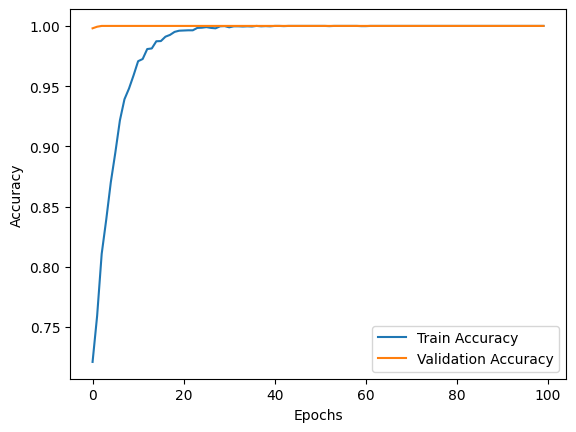


ADAM ile islem bitti.



In [ ]:
# !!! 31. epoch sonrasinda modeil Overfitting olmaktadir.
# Sonrasinda ise hic duzelmemektedir.
# Bundan dolayi 100. epoch'a kadar gidilmistir.


# Model egitimi gerceklestirildi.

for name, optimizer in optimizers.items():
    print(f"\n{name} ile isleme baslandi.\n")
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        # factor=0.3,
        # patience=1,
        # factor=0.1,
        factor=0.2,
        patience=5,
        min_lr=1e-6
    )

    # early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        # epochs=5,
        epochs=100,
        callbacks=[early_stopping, reduce_lr, checkpoint]
    )

    # Epoch basina Accuracy/Loss grafikleri cizdirildi.
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    print(f"\n{name} ile islem bitti.\n")

In [ ]:
# En iyi model yuklendi.
model = load_model(SAVE_PATH)

In [ ]:
# Test verisi uzerinde tahminlemede bulunuldu.
Y_true = []
Y_pred = []
for images, labels in test_generator:
    preds = model.predict(images)
    Y_pred.extend((preds > 0.5).astype(int))
    Y_true.extend(labels.astype(int))
    if len(Y_true) >= test_generator.samples:
        break

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


In [ ]:
# Test veriseti dogrulugu hesaplandi.

# !!! Overfitting oldugu icin 1-%100 degeri cikti.
# Tekrardan 36. epoch baz alinip kod calistirilamadigi icin, sonuc bu sekilde gelmektedir.

accuracy = np.mean(np.array(Y_true) == np.array(Y_pred))
print(f"Test Set Accuracy: {accuracy:.4f}")

Test Set Accuracy: 1.0000


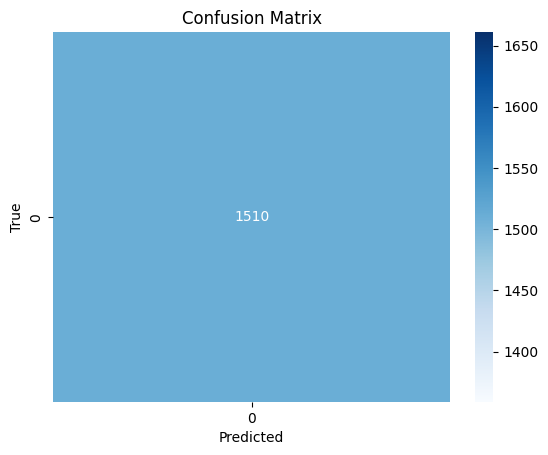

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1510

    accuracy                           1.00      1510
   macro avg       1.00      1.00      1.00      1510
weighted avg       1.00      1.00      1.00      1510



In [ ]:
# Confusion Matrix ve Performans Metrikleri

# !!! Overfitting.

conf_matrix = confusion_matrix(Y_true, Y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Classification Report:")
print(classification_report(Y_true, Y_pred))

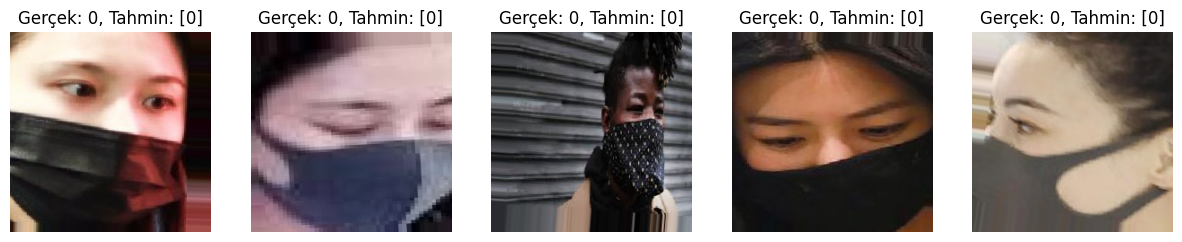

In [ ]:
# Rastgele 5 goruntu icin tahminleme yapildi.
#Tum sonuclar; rastgele olarak dogru cikti.

indices = random.sample(range(len(Y_true)), 5)
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(test_generator[i][0][0])
    ax.set_title(f"Gerçek: {Y_true[indices[i]]}, Tahmin: {Y_pred[indices[i]]}")
    ax.axis("off")
plt.show()

### STATIK EPOCH DENEMESI


ADAM ile isleme baslandi.

Epoch 1/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6407 - loss: 13.9626

95/95 ━━━━━━━━━━━━━━━━━━━━ 386s 2s/step - accuracy: 0.6409 - loss: 13.9623 - val_accuracy: 0.9497 - val_loss: 13.8487 - learning_rate: 1.0000e-06
Epoch 2/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.7084 - loss: 13.8531

95/95 ━━━━━━━━━━━━━━━━━━━━ 84s 888ms/step - accuracy: 0.7085 - loss: 13.8529 - val_accuracy: 0.9715 - val_loss: 13.7933 - learning_rate: 1.0000e-06
Epoch 3/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.7516 - loss: 13.7759

95/95 ━━━━━━━━━━━━━━━━━━━━ 84s 883ms/step - accuracy: 0.7517 - loss: 13.7757 - val_accuracy: 0.9861 - val_loss: 13.7380 - learning_rate: 1.0000e-06
Epoch 4/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/step - accuracy: 0.7903 - loss: 13.7076

95/95 ━━━━━━━━━━━━━━━━━━━━ 84s 883ms/step - accuracy: 0.7905 - loss: 13.7074 - val_accuracy: 0.9980 - val_loss: 13.6817 - learning_rate: 1.0000e-06
Epoch 5/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.8363 - loss: 13.6298

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 878ms/step - accuracy: 0.8364 - loss: 13.6297 - val_accuracy: 0.9993 - val_loss: 13.6219 - learning_rate: 1.0000e-06
Epoch 6/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.8681 - loss: 13.5622

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 879ms/step - accuracy: 0.8682 - loss: 13.5620 - val_accuracy: 1.0000 - val_loss: 13.5638 - learning_rate: 1.0000e-06
Epoch 7/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.8898 - loss: 13.4996

95/95 ━━━━━━━━━━━━━━━━━━━━ 84s 886ms/step - accuracy: 0.8899 - loss: 13.4994 - val_accuracy: 1.0000 - val_loss: 13.5064 - learning_rate: 1.0000e-06
Epoch 8/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.9138 - loss: 13.4403

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 881ms/step - accuracy: 0.9139 - loss: 13.4401 - val_accuracy: 1.0000 - val_loss: 13.4525 - learning_rate: 1.0000e-06
Epoch 9/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.9212 - loss: 13.3899

95/95 ━━━━━━━━━━━━━━━━━━━━ 84s 881ms/step - accuracy: 0.9213 - loss: 13.3898 - val_accuracy: 1.0000 - val_loss: 13.4019 - learning_rate: 1.0000e-06
Epoch 10/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9456 - loss: 13.3301

95/95 ━━━━━━━━━━━━━━━━━━━━ 84s 887ms/step - accuracy: 0.9456 - loss: 13.3300 - val_accuracy: 1.0000 - val_loss: 13.3518 - learning_rate: 1.0000e-06
Epoch 11/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 0.9529 - loss: 13.2892

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 879ms/step - accuracy: 0.9529 - loss: 13.2891 - val_accuracy: 1.0000 - val_loss: 13.3039 - learning_rate: 1.0000e-06
Epoch 12/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.9679 - loss: 13.2338

95/95 ━━━━━━━━━━━━━━━━━━━━ 84s 886ms/step - accuracy: 0.9679 - loss: 13.2337 - val_accuracy: 1.0000 - val_loss: 13.2606 - learning_rate: 1.0000e-06
Epoch 13/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.9721 - loss: 13.1914

95/95 ━━━━━━━━━━━━━━━━━━━━ 84s 886ms/step - accuracy: 0.9721 - loss: 13.1912 - val_accuracy: 1.0000 - val_loss: 13.2150 - learning_rate: 1.0000e-06
Epoch 14/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.9766 - loss: 13.1493

95/95 ━━━━━━━━━━━━━━━━━━━━ 84s 884ms/step - accuracy: 0.9767 - loss: 13.1492 - val_accuracy: 1.0000 - val_loss: 13.1703 - learning_rate: 1.0000e-06
Epoch 15/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.9859 - loss: 13.1016

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 879ms/step - accuracy: 0.9859 - loss: 13.1015 - val_accuracy: 1.0000 - val_loss: 13.1284 - learning_rate: 1.0000e-06
Epoch 16/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 0.9859 - loss: 13.0646

95/95 ━━━━━━━━━━━━━━━━━━━━ 84s 879ms/step - accuracy: 0.9860 - loss: 13.0645 - val_accuracy: 1.0000 - val_loss: 13.0877 - learning_rate: 1.0000e-06
Epoch 17/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.9867 - loss: 13.0286

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 879ms/step - accuracy: 0.9867 - loss: 13.0284 - val_accuracy: 1.0000 - val_loss: 13.0463 - learning_rate: 1.0000e-06
Epoch 18/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.9903 - loss: 12.9869

95/95 ━━━━━━━━━━━━━━━━━━━━ 84s 881ms/step - accuracy: 0.9904 - loss: 12.9868 - val_accuracy: 1.0000 - val_loss: 13.0063 - learning_rate: 1.0000e-06
Epoch 19/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.9939 - loss: 12.9453

95/95 ━━━━━━━━━━━━━━━━━━━━ 84s 882ms/step - accuracy: 0.9939 - loss: 12.9452 - val_accuracy: 1.0000 - val_loss: 12.9662 - learning_rate: 1.0000e-06
Epoch 20/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/step - accuracy: 0.9930 - loss: 12.9117

95/95 ━━━━━━━━━━━━━━━━━━━━ 84s 883ms/step - accuracy: 0.9930 - loss: 12.9116 - val_accuracy: 1.0000 - val_loss: 12.9267 - learning_rate: 1.0000e-06
Epoch 21/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.9950 - loss: 12.8742

95/95 ━━━━━━━━━━━━━━━━━━━━ 84s 886ms/step - accuracy: 0.9950 - loss: 12.8741 - val_accuracy: 1.0000 - val_loss: 12.8893 - learning_rate: 1.0000e-06
Epoch 22/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9942 - loss: 12.8422

95/95 ━━━━━━━━━━━━━━━━━━━━ 84s 889ms/step - accuracy: 0.9943 - loss: 12.8421 - val_accuracy: 1.0000 - val_loss: 12.8505 - learning_rate: 1.0000e-06
Epoch 23/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.9977 - loss: 12.8020

95/95 ━━━━━━━━━━━━━━━━━━━━ 84s 890ms/step - accuracy: 0.9977 - loss: 12.8019 - val_accuracy: 1.0000 - val_loss: 12.8128 - learning_rate: 1.0000e-06
Epoch 24/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.9975 - loss: 12.7647

95/95 ━━━━━━━━━━━━━━━━━━━━ 84s 884ms/step - accuracy: 0.9975 - loss: 12.7646 - val_accuracy: 1.0000 - val_loss: 12.7750 - learning_rate: 1.0000e-06
Epoch 25/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 0.9975 - loss: 12.7306

95/95 ━━━━━━━━━━━━━━━━━━━━ 84s 887ms/step - accuracy: 0.9975 - loss: 12.7305 - val_accuracy: 1.0000 - val_loss: 12.7391 - learning_rate: 1.0000e-06
Epoch 26/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.9981 - loss: 12.6939

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 877ms/step - accuracy: 0.9981 - loss: 12.6938 - val_accuracy: 1.0000 - val_loss: 12.7010 - learning_rate: 1.0000e-06
Epoch 27/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.9982 - loss: 12.6574

95/95 ━━━━━━━━━━━━━━━━━━━━ 84s 884ms/step - accuracy: 0.9982 - loss: 12.6573 - val_accuracy: 1.0000 - val_loss: 12.6632 - learning_rate: 1.0000e-06
Epoch 28/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.9992 - loss: 12.6204

95/95 ━━━━━━━━━━━━━━━━━━━━ 84s 879ms/step - accuracy: 0.9992 - loss: 12.6204 - val_accuracy: 1.0000 - val_loss: 12.6273 - learning_rate: 1.0000e-06
Epoch 29/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.9992 - loss: 12.5884

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 873ms/step - accuracy: 0.9992 - loss: 12.5884 - val_accuracy: 1.0000 - val_loss: 12.5900 - learning_rate: 1.0000e-06
Epoch 30/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.9994 - loss: 12.5513

95/95 ━━━━━━━━━━━━━━━━━━━━ 84s 884ms/step - accuracy: 0.9994 - loss: 12.5512 - val_accuracy: 1.0000 - val_loss: 12.5537 - learning_rate: 1.0000e-06
Epoch 31/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.9996 - loss: 12.5165

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 875ms/step - accuracy: 0.9996 - loss: 12.5164 - val_accuracy: 1.0000 - val_loss: 12.5172 - learning_rate: 1.0000e-06
Epoch 32/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.9996 - loss: 12.4805

95/95 ━━━━━━━━━━━━━━━━━━━━ 84s 882ms/step - accuracy: 0.9996 - loss: 12.4804 - val_accuracy: 1.0000 - val_loss: 12.4806 - learning_rate: 1.0000e-06
Epoch 33/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.9993 - loss: 12.4473

95/95 ━━━━━━━━━━━━━━━━━━━━ 84s 884ms/step - accuracy: 0.9993 - loss: 12.4472 - val_accuracy: 1.0000 - val_loss: 12.4444 - learning_rate: 1.0000e-06
Epoch 34/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.9999 - loss: 12.4134

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 873ms/step - accuracy: 0.9999 - loss: 12.4133 - val_accuracy: 1.0000 - val_loss: 12.4079 - learning_rate: 1.0000e-06
Epoch 35/35
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.9990 - loss: 12.3774

95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 879ms/step - accuracy: 0.9990 - loss: 12.3773 - val_accuracy: 1.0000 - val_loss: 12.3717 - learning_rate: 1.0000e-06


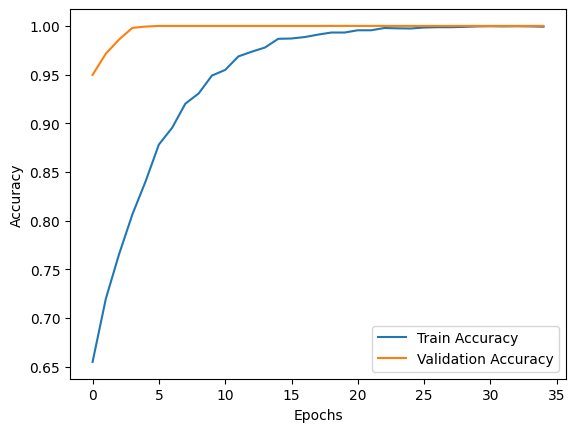


ADAM ile islem bitti.



In [17]:
# !!! 36. epoch sonrasinda modeil Overfitting olmaktadir.
# Sonrasinda ise hic duzelmemektedir.
# Bundan dolayi 36. epoch'a kadar gidilmistir.


# Model egitimi gerceklestirildi.

for name, optimizer in optimizers.items():
    print(f"\n{name} ile isleme baslandi.\n")
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        # factor=0.3,
        # patience=1,
        # factor=0.1,
        factor=0.2,
        patience=5,
        min_lr=1e-6
    )

    # early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        # epochs=5,
        epochs=35,
        callbacks=[early_stopping, reduce_lr, checkpoint]
    )

    # Epoch basina Accuracy/Loss grafikleri cizdirildi.
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    print(f"\n{name} ile islem bitti.\n")

In [18]:
# En iyi model yuklendi.
model = load_model(SAVE_PATH)

In [19]:
# Test verisi uzerinde tahminlemede bulunuldu.
Y_true = []
Y_pred = []
for images, labels in test_generator:
    preds = model.predict(images)
    Y_pred.extend((preds > 0.5).astype(int))
    Y_true.extend(labels.astype(int))
    if len(Y_true) >= test_generator.samples:
        break

2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


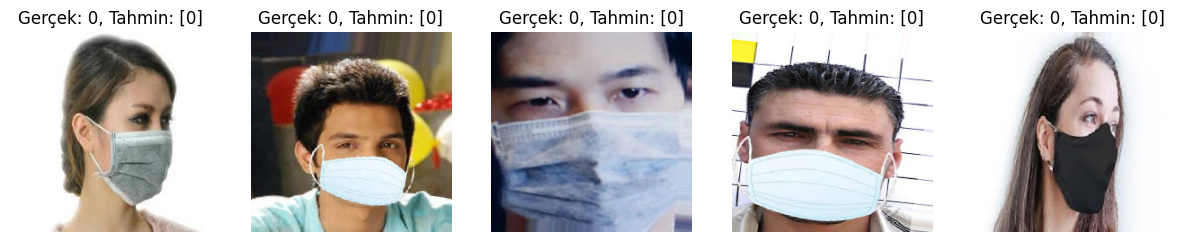

In [26]:
# 35. epoch icin tahminler.

# Rastgele 5 goruntu icin tahminleme yapildi.

indices = random.sample(range(len(Y_true)), 5)
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(test_generator[i][0][0])
    ax.set_title(f"Gerçek: {Y_true[indices[i]]}, Tahmin: {Y_pred[indices[i]]}")
    ax.axis("off")
plt.show()